In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import os, sys
import timm
import torch.nn.functional as F
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from collections import OrderedDict
from transformers.models.distilbert.modeling_distilbert import Transformer as T
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
torch.multiprocessing.set_sharing_strategy('file_descriptor')

/home/anton/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-09-09 01:58:04.276477: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 01:58:04.297547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 01:58:04.297568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 01:58:04.298165: E external/local_xla/xla/stream_exec

In [2]:
rd = 'rsna-2024-lumbar-spine-degenerative-classification'
OUTPUT_DIR = 'rsna-results-2.5d'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = [256, 256]
N_FOLDS = 5
EPOCHS = 100
USE_AMP = True
N_LABELS = 25
N_CLASSES = 3 * N_LABELS
AUG_PROB = 0.75
SELECTED_FOLDS = [0, 1, 2, 3, 4]
SEED = 69
GRAD_ACC = 1
TGT_BATCH_SIZE = 8
IN_CHANS = 18
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC // 2
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 20
LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True
MODEL_NAME = 'convnext_pico.d1_in1k'
# MODEL_NAME = 'edgenext_base.in21k_ft_in1k'

# MODEL_NAME = 'convnextv2_pico.fcmae'
NOT_DEBUG = True
N_WORKERS = 4

In [3]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

In [5]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [6]:
df = df.fillna(-100)

In [7]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_26968/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]
model_names = list(df.columns)[1:]
model_names

['spinal_canal_stenosis_l1_l2',
 'spinal_canal_stenosis_l2_l3',
 'spinal_canal_stenosis_l3_l4',
 'spinal_canal_stenosis_l4_l5',
 'spinal_canal_stenosis_l5_s1',
 'left_neural_foraminal_narrowing_l1_l2',
 'left_neural_foraminal_narrowing_l2_l3',
 'left_neural_foraminal_narrowing_l3_l4',
 'left_neural_foraminal_narrowing_l4_l5',
 'left_neural_foraminal_narrowing_l5_s1',
 'right_neural_foraminal_narrowing_l1_l2',
 'right_neural_foraminal_narrowing_l2_l3',
 'right_neural_foraminal_narrowing_l3_l4',
 'right_neural_foraminal_narrowing_l4_l5',
 'right_neural_foraminal_narrowing_l5_s1',
 'left_subarticular_stenosis_l1_l2',
 'left_subarticular_stenosis_l2_l3',
 'left_subarticular_stenosis_l3_l4',
 'left_subarticular_stenosis_l4_l5',
 'left_subarticular_stenosis_l5_s1',
 'right_subarticular_stenosis_l1_l2',
 'right_subarticular_stenosis_l2_l3',
 'right_subarticular_stenosis_l3_l4',
 'right_subarticular_stenosis_l4_l5',
 'right_subarticular_stenosis_l5_s1']

In [9]:
from pathlib import Path
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS, 3), dtype=np.float32)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1

        sat1 = glob(f'cvt_png/{st_id}/Sagittal T1/*.png')
        sat1 = sorted(sat1)
    
        step = len(sat1) / (IN_CHANS - 1)
        st = 0
        end = len(sat1)+0.0001
        if len(sat1) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = sat1[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i, 0] = img.astype(np.float32)
                except:
#                     print(f'failed to load on {st_id}, Sagittal T1')
                    pass
            
        #Sagittal T2/STIR
        sat2 = glob(f'cvt_png/{st_id}/Sagittal T2_STIR/*.png')
        sat2 = sorted(sat2)
    
        step = len(sat2) / (IN_CHANS - 1)
        st = 0
        end = len(sat2)+0.0001

        if len(sat2) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = sat2[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i, 1] = img.astype(np.float32)
                except:
#                     print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass
            
        # Axial T2
        axt2 = glob(f'cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / (IN_CHANS - 1)
        st = 0
        end = len(axt2)+0.0001

        if len(axt2) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = axt2[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i, 2] = img.astype(np.float32)
                except:
#                     print(f'failed to load on {st_id}, Axial T2')
                    pass  
            
#         assert np.sum(x)>0
        if self.transform is not None:
            for i in range(x.shape[-1]):
                x[..., i] = self.transform(image=x[..., i])['image']

        x = x.transpose(2, 3, 0, 1)
        
                
        return x, label

In [10]:
transforms_train = A.Compose([
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=50),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
#     A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=2, min_width=2, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not AUG:
    transforms_train = transforms_val

/home/anton/anaconda3/lib/python3.11/site-packages/albumentations/augmentations/blur/transforms.py:189: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


x stat: torch.Size([1, 18, 3, 256, 256]) tensor(-1.) tensor(0.9018) tensor(-0.8204) tensor(0.3303)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


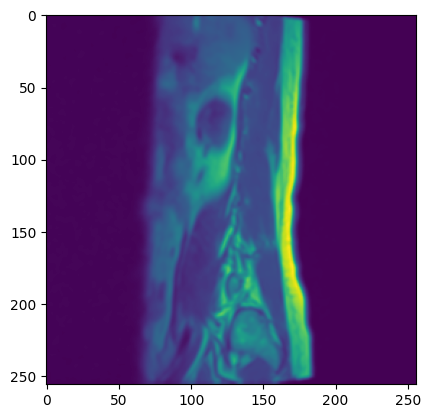

y stat: (256, 256) -1.0 0.7974878 -0.7460747 0.3573871

x stat: torch.Size([1, 18, 3, 256, 256]) tensor(-1.) tensor(0.9634) tensor(-0.7002) tensor(0.2860)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


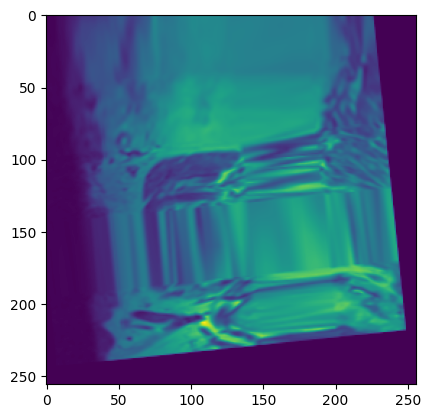

y stat: (256, 256) -1.0 0.2885539 -0.61650914 0.27716556



In [11]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=False,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==2:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy()[0,1,0,:,:]
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [12]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
#         nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
        



In [13]:
class TimmModelCombo(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModelCombo, self).__init__()

        self.encoder_sagittal = timm.create_model(
            backbone,
            in_chans=2,
            num_classes=1,
            features_only=False,
            drop_rate=0.4,
            pretrained=pretrained
        )
        
        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=1,
            num_classes=1,
            features_only=False,
            drop_rate=0.4,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagittal.conv_head.out_channels
            self.encoder_sagittal.classifier = nn.Identity()
            self.encoder_axial.classifier = nn.Identity()
            
        elif 'convnext' in backbone:
            hdim = self.encoder_sagittal.head.fc.in_features
            self.encoder_sagittal.head.fc = nn.Identity()
            self.encoder_axial.head.fc = nn.Identity()
            
        if 'densenet121' in backbone:
            hdim = 1024
            self.encoder_sagittal.classifier = nn.Identity()
            self.encoder_axial.classifier = nn.Identity()
            
        if 'densenet161' in backbone:
            hdim = 2208
            self.encoder_sagittal.classifier = nn.Identity()
            self.encoder_axial.classifier = nn.Identity()
            
        if 'densenet201' in backbone:
            hdim = 1920
            self.encoder_sagittal.classifier = nn.Identity()
            self.encoder_axial.classifier = nn.Identity()


#         self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=0., bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 75),
        )
        self.attention_layer_sagittal = Attention(512, IN_CHANS)
        self.attention_layer_axial = Attention(512, IN_CHANS)
        
        self.fc_axial = nn.Sequential(
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.SiLU()
        )
        self.fc_sagittal = nn.Sequential(
            nn.Linear(512, 256), 
            nn.Dropout(0.3),
            nn.SiLU()
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        img_size = x.shape[3]
        
        x_sagittal = x[:, :, :2, :, :]
        x_axial = x[:, :, 2:3, :, :]
        
        x_sagittal = x_sagittal.view(bs * IN_CHANS, x_sagittal.shape[2], img_size, img_size)
        feat_sagittal = self.encoder_sagittal(x_sagittal)
        feat_sagittal = feat_sagittal.view(bs, IN_CHANS, -1)
        
        x_axial = x_axial.view(bs * IN_CHANS, x_axial.shape[2], img_size, img_size)
        feat_axial = self.encoder_axial(x_axial)
        feat_axial = feat_axial.view(bs, IN_CHANS, -1)
#         feat_lstm, _ = self.lstm(feat)
#         feat_lstm = feat_lstm.contiguous().view(bs * 12, -1)
#         feat_lstm = self.head(feat_lstm)
#         feat_lstm = feat_lstm.view(bs, 12, 75).contiguous()
        atten_sagittal = self.attention_layer_sagittal(feat_sagittal)
        atten_axial = self.attention_layer_axial(feat_axial)
#         atten = torch.cat((atten_sagittal, atten_axial), dim=1)
        atten_sagittal = self.fc_sagittal(atten_sagittal)
        atten_axial = self.fc_axial(atten_axial)
        atten = (atten_sagittal + atten_axial) / 2
        out = self.head(atten)
        return out

In [14]:

class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=2,
            num_classes=1,
            features_only=False,
            drop_rate=0.4,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()
            
        if 'densenet121' in backbone:
            hdim = 1024
            self.encoder.classifier = nn.Identity()
            
        if 'densenet161' in backbone:
            hdim = 2208
            self.encoder.classifier = nn.Identity()
        if 'densenet201' in backbone:
            hdim = 1920
            self.encoder.classifier = nn.Identity()
            
        if 'edgenext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=1, dropout=0., bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hdim, 256),
            nn.Dropout(0.4),
            nn.SiLU(),
            nn.Linear(256, 75),
        )
        self.attention_layer = Attention(hdim, IN_CHANS)

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        x = x[:, :, 0:2, :, :]
        bs = x.shape[0]
        img_size = x.shape[3]
        x = x.view(bs * IN_CHANS, 2, img_size, img_size)

        feat = self.encoder(x)
        feat = feat.view(bs, IN_CHANS, -1)
        
        
#         feat_lstm, _ = self.lstm(feat)
        
#         feat_lstm = feat_lstm.contiguous().view(bs * 12, -1)
#         feat_lstm = self.head(feat_lstm)
#         feat_lstm = feat_lstm.view(bs, 12, 75).contiguous()
        atten = self.attention_layer(feat)
        
        out = self.head(atten)
        return out





In [15]:
m = TimmModel(MODEL_NAME)
m = m.to(DEVICE)
i = torch.randn(8, IN_CHANS, 3, 224, 224).to(DEVICE)
with torch.no_grad():
    out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-0.2002, device='cuda:0') tensor(0.1805, device='cuda:0')
torch.Size([75]) tensor(-0.2154, device='cuda:0') tensor(0.2580, device='cuda:0')
torch.Size([75]) tensor(-0.2506, device='cuda:0') tensor(0.1874, device='cuda:0')
torch.Size([75]) tensor(-0.2055, device='cuda:0') tensor(0.2172, device='cuda:0')
torch.Size([75]) tensor(-0.1458, device='cuda:0') tensor(0.1591, device='cuda:0')
torch.Size([75]) tensor(-0.2575, device='cuda:0') tensor(0.1265, device='cuda:0')
torch.Size([75]) tensor(-0.1818, device='cuda:0') tensor(0.1857, device='cuda:0')
torch.Size([75]) tensor(-0.1685, device='cuda:0') tensor(0.1704, device='cuda:0')


In [16]:
del m, i, out
torch.cuda.empty_cache()

In [17]:
# m = RSNA24Model('efficientnet_b0', in_c=1, n_classes=512, pretrained=False)
# m = m.to(DEVICE)
# i = torch.randn(2, IN_CHANS // 3, 256, 256).to(DEVICE)
# out = m(i)
# for o in out:
#     print(o.shape, o.min(), o.max())

In [18]:
# del m, i, out

In [19]:
%time
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=2048)

val_losses = []
train_losses = []
df_tr, df_test = train_test_split(df, test_size=2/7, random_state=SEED)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
device = DEVICE

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    loss_scale = 1
    if NOT_DEBUG == False:
        if fold == 1: break;
    if fold not in SELECTED_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        print(len(trn_idx), len(val_idx))
        df_train = df.iloc[trn_idx]
        df_valid = df.iloc[val_idx]

        train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
        train_dl = DataLoader(
                        train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        pin_memory=False,
                        drop_last=True,
                        num_workers=N_WORKERS
                        )

        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                        valid_ds,
                        batch_size=BATCH_SIZE*2,
                        shuffle=False,
                        pin_memory=False,
                        drop_last=False,
                        num_workers=N_WORKERS
                        )

    #         model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
        model = TimmModel(MODEL_NAME, pretrained=True)
            
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
    #         if os.path.exists(fname):
    #             model = TimmModel(MODEL_NAME, pretrained=False)
    #             model.load_state_dict(torch.load(fname))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LR*2, weight_decay=WD)
    #         optimizer = torch.optim.SGD(model.parameters(), lr=LR*2, weight_decay=WD, nesterov=True, momentum=0.9)

        warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
        num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
        num_cycles = 0.475
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                        num_warmup_steps=warmup_steps,
                                                        num_training_steps=num_total_steps,
                                                        num_cycles=num_cycles)
    #         scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                                     num_warmup_steps=warmup_steps,
    #                                                     num_training_steps=num_total_steps)

        weights = torch.tensor([1.0, 2.0, 4.0])
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        criterion_cpu = nn.CrossEntropyLoss(weight=weights)
        best_loss = 1.2
        es_step = 0

        for epoch in range(1, EPOCHS+1):
            print(f'start epoch {epoch}')
            model.train()
            total_loss = 0
            with tqdm(train_dl, leave=True) as pbar:
                optimizer.zero_grad()
                for idx, (x, t) in enumerate(pbar):  
                    op = ['nothing', 'nothing', 'nothing', 'nothing', 'nothing']
                    x = x.to(device)
                    t = t.to(device)
    #                     t = torch.tensor(np.array(one_h(list(t.detach().cpu().numpy())))).to(device)
                    rc = random.sample(op, 1)
                    if rc[0] == 'mixup':
                        x = x.detach().cpu().numpy()
                        t = t.detach().cpu().numpy()
                        reference_data = [{'image':x[i], 'proba': t[i]} 
                                            for i in range(len(x))]
                        tr = A.Compose([A.MixUp(reference_data=reference_data,
                                                  read_fn=read_fn, p=0.5)])
                        for i in range(len(x)):
                            transformed = tr(image=x[i], global_label=t[i])
                            x[i] = transformed['image']
                            t[i] = transformed['global_label']

                        x = torch.tensor(x).to(device)
                        t = torch.tensor(t).to(device)

                    with autocast:
                        loss = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
                            loss = loss + loss_scale * criterion(pred, gt) / N_LABELS

                        if not math.isfinite(loss):
                            loss = torch.tensor(1.2 * loss_scale * GRAD_ACC, requires_grad=True)
                        total_loss += loss.item()
                        if GRAD_ACC > 1:
                            loss = loss / GRAD_ACC




                    pbar.set_postfix(
                            OrderedDict(
                                loss=f'{loss.item()*GRAD_ACC:.6f}',
                                lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                            )
                    )
    #                     scaler.scale(loss).backward()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                    if (idx + 1) % GRAD_ACC == 0:
    #                         scaler.step(optimizer)
    #                         scaler.update()
                        optimizer.step()
                        optimizer.zero_grad()
                        if scheduler is not None:
                            scheduler.step()                    

            train_loss = total_loss/len(train_dl)
            print(f'train_loss:{train_loss/loss_scale:.6f}')
            train_losses.append(train_loss)
            total_loss = 0

            model.eval()
            y_preds, labels = [], []
            with tqdm(valid_dl, leave=True) as pbar:
                with torch.no_grad():
                    for idx, (x, t) in enumerate(pbar):

                        x = x.to(device)
                        t = t.to(device)

                        with autocast:
                            loss = 0
                            loss_ema = 0
                            y = model(x)
                            for col in range(N_LABELS):
                                pred = y[:,col*3:col*3+3]
                                gt = t[:,col]

                                loss = loss + criterion(pred, gt) / N_LABELS
                                y_pred = pred.float()
                                y_preds.append(y_pred.cpu())
                                labels.append(gt.cpu())

                            if not math.isfinite(loss):
                                loss = torch.tensor(1.2 * loss_scale * GRAD_ACC, requires_grad=True)

                            total_loss += loss.item()   

            val_loss = total_loss/len(valid_dl)
            y_preds = torch.cat(y_preds, dim=0)
            print(y_preds.shape)
            labels = torch.cat(labels)

            val_weighted_loss = criterion_cpu(y_preds, labels)
            writer.add_scalar('val_wll', val_weighted_loss, epoch)
            writer.flush()
            print(f'val_loss:{val_loss:.6f}')
            val_losses.append(val_loss)
            if val_weighted_loss < best_loss:

                if device!='cuda:0':
                        model.to('cuda:0')                

                print(f'epoch:{epoch}, best weighted_logloss updated from {best_loss:.6f} to {val_weighted_loss:.6f}')
                best_loss = val_weighted_loss
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
                print(f'{fname} is saved')
                es_step = 0

                if device!='cuda:0':
                    model.to(device)

            else:
                es_step += 1
                if es_step >= EARLY_STOPPING_EPOCH:
                    print('early stopping')
                    break  
                                

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
##############################
Start fold 0
##############################
1580 395
start epoch 1


100%|████████████| 395/395 [01:07<00:00,  5.83it/s, loss=0.611622, lr=9.975e-06]


train_loss:0.932401


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.81it/s]


torch.Size([9875, 3])
val_loss:0.809261
epoch:1, best weighted_logloss updated from 1.200000 to 0.881560
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 2


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.563265, lr=1.997e-05]


train_loss:0.795670


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.96it/s]


torch.Size([9875, 3])
val_loss:0.789767
epoch:2, best weighted_logloss updated from 0.881560 to 0.869078
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 3


100%|████████████| 395/395 [01:03<00:00,  6.23it/s, loss=1.081664, lr=2.997e-05]


train_loss:0.759590


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.91it/s]


torch.Size([9875, 3])
val_loss:0.733404
epoch:3, best weighted_logloss updated from 0.869078 to 0.814564
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 4


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.682840, lr=3.997e-05]


train_loss:0.730619


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.94it/s]


torch.Size([9875, 3])
val_loss:0.745755
start epoch 5


100%|████████████| 395/395 [01:03<00:00,  6.26it/s, loss=0.570146, lr=4.997e-05]


train_loss:0.709592


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.90it/s]


torch.Size([9875, 3])
val_loss:0.680327
epoch:5, best weighted_logloss updated from 0.814564 to 0.754235
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 6


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.711932, lr=5.997e-05]


train_loss:0.694436


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.92it/s]


torch.Size([9875, 3])
val_loss:0.662342
epoch:6, best weighted_logloss updated from 0.754235 to 0.720023
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 7


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.967436, lr=6.997e-05]


train_loss:0.672581


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.92it/s]


torch.Size([9875, 3])
val_loss:0.706615
start epoch 8


100%|████████████| 395/395 [01:03<00:00,  6.23it/s, loss=0.578874, lr=7.997e-05]


train_loss:0.657226


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


torch.Size([9875, 3])
val_loss:0.628738
epoch:8, best weighted_logloss updated from 0.720023 to 0.693919
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 9


100%|████████████| 395/395 [01:03<00:00,  6.22it/s, loss=0.896233, lr=8.997e-05]


train_loss:0.640828


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.91it/s]


torch.Size([9875, 3])
val_loss:0.623976
epoch:9, best weighted_logloss updated from 0.693919 to 0.691930
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 10


100%|████████████| 395/395 [01:03<00:00,  6.23it/s, loss=0.740689, lr=9.997e-05]


train_loss:0.638365


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.86it/s]


torch.Size([9875, 3])
val_loss:0.646894
start epoch 11


100%|████████████| 395/395 [01:03<00:00,  6.22it/s, loss=0.486409, lr=9.997e-05]


train_loss:0.627211


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


torch.Size([9875, 3])
val_loss:0.659928
start epoch 12


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=1.058919, lr=9.989e-05]


train_loss:0.617414


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]


torch.Size([9875, 3])
val_loss:0.653876
start epoch 13


100%|████████████| 395/395 [01:03<00:00,  6.25it/s, loss=0.520505, lr=9.975e-05]


train_loss:0.616112


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


torch.Size([9875, 3])
val_loss:0.637763
start epoch 14


100%|████████████| 395/395 [01:03<00:00,  6.23it/s, loss=0.314142, lr=9.956e-05]


train_loss:0.610605


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


torch.Size([9875, 3])
val_loss:0.643225
start epoch 15


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.538218, lr=9.931e-05]


train_loss:0.603571


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


torch.Size([9875, 3])
val_loss:0.625075
start epoch 16


100%|████████████| 395/395 [01:03<00:00,  6.19it/s, loss=0.620023, lr=9.901e-05]


train_loss:0.596091


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


torch.Size([9875, 3])
val_loss:0.623563
start epoch 17


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.495567, lr=9.866e-05]


train_loss:0.597756


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


torch.Size([9875, 3])
val_loss:0.597009
epoch:17, best weighted_logloss updated from 0.691930 to 0.657396
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 18


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.469199, lr=9.825e-05]


train_loss:0.599749


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


torch.Size([9875, 3])
val_loss:0.602944
start epoch 19


100%|████████████| 395/395 [01:03<00:00,  6.23it/s, loss=0.548188, lr=9.779e-05]


train_loss:0.589378


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


torch.Size([9875, 3])
val_loss:0.591892
epoch:19, best weighted_logloss updated from 0.657396 to 0.656025
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 20


100%|████████████| 395/395 [01:04<00:00,  6.17it/s, loss=0.516165, lr=9.728e-05]


train_loss:0.582778


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


torch.Size([9875, 3])
val_loss:0.598066
start epoch 21


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.398317, lr=9.671e-05]


train_loss:0.589229


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.79it/s]


torch.Size([9875, 3])
val_loss:0.588737
epoch:21, best weighted_logloss updated from 0.656025 to 0.651283
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 22


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.632624, lr=9.609e-05]


train_loss:0.583404


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


torch.Size([9875, 3])
val_loss:0.601627
start epoch 23


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.923355, lr=9.543e-05]


train_loss:0.582078


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


torch.Size([9875, 3])
val_loss:0.591310
start epoch 24


100%|████████████| 395/395 [01:03<00:00,  6.25it/s, loss=0.606021, lr=9.471e-05]


train_loss:0.568278


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


torch.Size([9875, 3])
val_loss:0.600849
start epoch 25


100%|████████████| 395/395 [01:03<00:00,  6.19it/s, loss=0.467602, lr=9.394e-05]


train_loss:0.569189


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


torch.Size([9875, 3])
val_loss:0.593850
start epoch 26


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.403895, lr=9.313e-05]


train_loss:0.574318


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


torch.Size([9875, 3])
val_loss:0.582874
epoch:26, best weighted_logloss updated from 0.651283 to 0.644918
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 27


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.897380, lr=9.227e-05]


train_loss:0.562845


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


torch.Size([9875, 3])
val_loss:0.592223
start epoch 28


100%|████████████| 395/395 [01:03<00:00,  6.19it/s, loss=0.622668, lr=9.136e-05]


train_loss:0.572453


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


torch.Size([9875, 3])
val_loss:0.592190
start epoch 29


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.892614, lr=9.040e-05]


train_loss:0.557375


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.89it/s]


torch.Size([9875, 3])
val_loss:0.575013
epoch:29, best weighted_logloss updated from 0.644918 to 0.632143
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 30


100%|████████████| 395/395 [01:03<00:00,  6.18it/s, loss=0.548274, lr=8.940e-05]


train_loss:0.557944


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.80it/s]


torch.Size([9875, 3])
val_loss:0.592401
start epoch 31


100%|████████████| 395/395 [01:03<00:00,  6.18it/s, loss=0.443881, lr=8.836e-05]


train_loss:0.557914


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.78it/s]


torch.Size([9875, 3])
val_loss:0.575854
start epoch 32


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.482774, lr=8.728e-05]


train_loss:0.549715


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


torch.Size([9875, 3])
val_loss:0.578500
epoch:32, best weighted_logloss updated from 0.632143 to 0.629790
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 33


100%|████████████| 395/395 [01:03<00:00,  6.18it/s, loss=0.874656, lr=8.615e-05]


train_loss:0.552362


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.90it/s]


torch.Size([9875, 3])
val_loss:0.568272
epoch:33, best weighted_logloss updated from 0.629790 to 0.624720
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 34


100%|████████████| 395/395 [01:03<00:00,  6.18it/s, loss=0.123257, lr=8.499e-05]


train_loss:0.543633


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


torch.Size([9875, 3])
val_loss:0.565127
epoch:34, best weighted_logloss updated from 0.624720 to 0.621602
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 35


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.398115, lr=8.378e-05]


train_loss:0.549946


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.81it/s]


torch.Size([9875, 3])
val_loss:0.560158
epoch:35, best weighted_logloss updated from 0.621602 to 0.614282
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 36


100%|████████████| 395/395 [01:04<00:00,  6.16it/s, loss=0.514362, lr=8.254e-05]


train_loss:0.543567


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.80it/s]


torch.Size([9875, 3])
val_loss:0.570098
start epoch 37


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.617760, lr=8.127e-05]


train_loss:0.538689


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.86it/s]


torch.Size([9875, 3])
val_loss:0.601419
start epoch 38


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.458323, lr=7.995e-05]


train_loss:0.534323


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


torch.Size([9875, 3])
val_loss:0.561721
epoch:38, best weighted_logloss updated from 0.614282 to 0.612074
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 39


100%|████████████| 395/395 [01:03<00:00,  6.22it/s, loss=0.642756, lr=7.861e-05]


train_loss:0.531745


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


torch.Size([9875, 3])
val_loss:0.572245
start epoch 40


100%|████████████| 395/395 [01:06<00:00,  5.96it/s, loss=0.440211, lr=7.724e-05]


train_loss:0.526033


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


torch.Size([9875, 3])
val_loss:0.616182
start epoch 41


100%|████████████| 395/395 [01:08<00:00,  5.74it/s, loss=0.427213, lr=7.583e-05]


train_loss:0.529870


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.79it/s]


torch.Size([9875, 3])
val_loss:0.564803
start epoch 42


100%|████████████| 395/395 [01:04<00:00,  6.15it/s, loss=0.338229, lr=7.440e-05]


train_loss:0.530545


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


torch.Size([9875, 3])
val_loss:0.569181
start epoch 43


100%|████████████| 395/395 [01:04<00:00,  6.14it/s, loss=0.577375, lr=7.294e-05]


train_loss:0.528494


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.85it/s]


torch.Size([9875, 3])
val_loss:0.567907
start epoch 44


100%|████████████| 395/395 [01:04<00:00,  6.12it/s, loss=0.401965, lr=7.145e-05]


train_loss:0.529176


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]


torch.Size([9875, 3])
val_loss:0.558899
start epoch 45


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.516326, lr=6.994e-05]


train_loss:0.521302


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


torch.Size([9875, 3])
val_loss:0.555899
start epoch 46


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.577913, lr=6.841e-05]


train_loss:0.517688


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


torch.Size([9875, 3])
val_loss:0.551236
epoch:46, best weighted_logloss updated from 0.612074 to 0.606678
rsna-results-2.5d/best_wll_model_fold-0.pt is saved
start epoch 47


100%|████████████| 395/395 [01:03<00:00,  6.21it/s, loss=0.536352, lr=6.686e-05]


train_loss:0.514903


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


torch.Size([9875, 3])
val_loss:0.571950
start epoch 48


100%|████████████| 395/395 [01:03<00:00,  6.20it/s, loss=0.577739, lr=6.529e-05]


train_loss:0.511728


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


torch.Size([9875, 3])
val_loss:0.589143
start epoch 49


100%|████████████| 395/395 [01:03<00:00,  6.23it/s, loss=0.513690, lr=6.370e-05]


train_loss:0.510989


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s]


torch.Size([9875, 3])
val_loss:0.578005
start epoch 50


100%|████████████| 395/395 [01:03<00:00,  6.18it/s, loss=0.820263, lr=6.210e-05]


train_loss:0.514465


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.86it/s]


torch.Size([9875, 3])
val_loss:0.555831
start epoch 51


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.610029, lr=6.049e-05]


train_loss:0.501225


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.81it/s]


torch.Size([9875, 3])
val_loss:0.556139
start epoch 52


100%|████████████| 395/395 [01:03<00:00,  6.24it/s, loss=0.644762, lr=5.886e-05]


train_loss:0.510850


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]


torch.Size([9875, 3])
val_loss:0.555906
start epoch 53


 36%|████▎       | 143/395 [00:24<00:43,  5.82it/s, loss=0.770905, lr=5.827e-05]


KeyboardInterrupt: 

In [ ]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer


## TODO: Modify EXIST_FOLDS by how many fold you've trained
EXIST_FOLDS = [0, 1, 2, 3, 4]
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    #     if NOT_DEBUG == False:
    #         if fold == 1: break;
    if fold not in EXIST_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                        valid_ds,
                        batch_size=16,
                        shuffle=False,
                        pin_memory=False,
                        drop_last=False,
                        num_workers=N_WORKERS
                        )
            

        model = TimmModelCombo(MODEL_NAME)
                
            # print("No internet read")
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
        model.load_state_dict(torch.load(fname))
        model.to(device)   

        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):

                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

In [ ]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())